In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import matplotlib.pyplot as plt
import random
import json
from dotenv import load_dotenv
import os
from tqdm import tqdm
import time
import networkx as nx
load_dotenv() 

/Users/dmitriimartynov/Documents/Projects/deeppavlov/chatsky-llm-autoconfig/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

## Cycle Graph Creation

Prompt

In [2]:
from langchain.prompts import PromptTemplate

cycle_graph_generation_prompt = PromptTemplate.from_template(
    '''
        Your task is to create a dialogue graph based on a given topic. 
        The dialogue must be written in English, consist of exactly two people talking, show user-assistant interaction, 
        and be cyclic (the last phrase should connect the last node with the first node). 
        You have an example of a dialogue from a customer chatbot system. 
        You also have an example of a set of rules describing how the chatbot system works—it is a set of nodes where the chatbot system responds 
        and a set of transitions that are triggered by user requests. 
        So NODES must consist of utterances from the assistant (chatbot), and EDGES must consist of utterances from the user.
        Here is the example of the set of rules:

        "edges": [
            {{ "source": 1, "target": 2, "utterances": ["I need to make an order", "I want to order from you"] }},
            {{ "source": 2, "target": 3, "utterances": ["I would like to purchase 'Pale Fire' and 'Anna Karenina', please", "I want to buy two books: 'Pale Fire' and 'Anna Karenina'"] }},
            {{ "source": 3, "target": 4, "utterances": ["Cash", "I'll pay in cash"] }},
            {{ "source": 3, "target": 4, "utterances": ["With credit card, please", "I'd like to pay by card"] }},
            {{ "source": 4, "target": 3, "utterances": ["I will enter a new payment method", "Let me try a different payment option"] }},
            {{ "source": 4, "target": 1, "utterances": ["Start new order", "I want to start over"] }}
        ],
         "nodes": [
            {{ "id": 1, "label": "start", "is_start": true, "utterances": ["How can I help?", "Welcome! What can I do for you?"] }},
            {{ "id": 2, "label": "ask_books", "is_start": false, "utterances": ["Which books would you like to order?", "What books are you interested in?"] }},
            {{ "id": 3, "label": "ask_payment_method", "is_start": false, "utterances": ["Please select your payment method: cash or credit card.", "How would you like to pay? We accept cash or credit card."] }},
            {{ "id": 4, "label": "ask_to_redo", "is_start": false, "utterances": ["Something went wrong. Would you like to try another payment method or start a new order?", "There seems to be an issue. You can try a different payment method or begin a new order."] }}
        ]

        Your task is to create a dialogue graph about the following topic: {topic}. 
        The graph must be a valid JSON string in the specified format, 
        using the structure and naming conventions from the examples. 
        Return ONLY the JSON string in plain text (no code blocks) without any additional commentaries. 
        All utterances must be arrays containing exactly 2 semantically equivalent variations of the same message.
        Come up with an original dialogue themed around the given topic.
    '''
)

In [14]:
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from typing import List, Optional
from langchain_core.output_parsers import JsonOutputParser

class Edge(BaseModel):
    source: int = Field(description="ID of the source node")
    target: int = Field(description="ID of the target node")
    utterances: str = Field(description="User's utterance that triggers this transition")

class Node(BaseModel):
    id: int = Field(description="Unique identifier for the node")
    label: str = Field(description="Label describing the node's purpose")
    is_start: bool = Field(description="Whether this is the starting node")
    utterances: List[str] = Field(description="Possible assistant responses at this node")

class DialogueGraph(BaseModel):
    edges: List[Edge] = Field(description="List of transitions between nodes")
    nodes: List[Node] = Field(description="List of nodes representing assistant states")


parser = JsonOutputParser(pydantic_object=DialogueGraph)


model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

generate_graph_chain = cycle_graph_generation_prompt | model | parser



In [25]:
graph = generate_graph_chain.invoke({"topic": "Dialog about cooking between assistant and customer"})

In [26]:
graph

{'edges': [{'source': 1,
   'target': 2,
   'utterances': 'I want to cook something delicious.'},
  {'source': 1, 'target': 2, 'utterances': 'Can you help me with a recipe?'},
  {'source': 2,
   'target': 3,
   'utterances': 'What type of dish are you interested in making?'},
  {'source': 3, 'target': 4, 'utterances': 'I want to make a pasta dish.'},
  {'source': 3, 'target': 4, 'utterances': "I'm thinking about a dessert."},
  {'source': 4,
   'target': 3,
   'utterances': 'Do you have any specific ingredients in mind?'},
  {'source': 4,
   'target': 1,
   'utterances': "Let's start over, I need a different recipe."}],
 'nodes': [{'id': 1,
   'label': 'start',
   'is_start': True,
   'utterances': ['Hello! How can I assist you with cooking today?',
    'What would you like to cook?']},
  {'id': 2,
   'label': 'ask_dish_type',
   'is_start': False,
   'utterances': ['What kind of dish are you looking to prepare?']},
  {'id': 3,
   'label': 'ask_ingredients',
   'is_start': False,
   'u

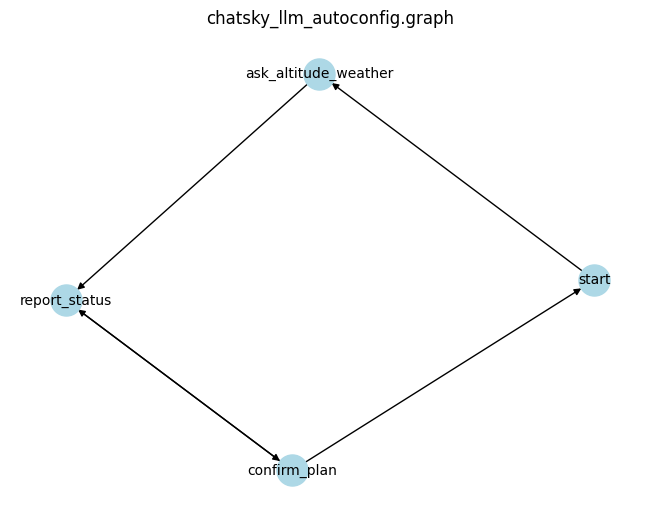

In [20]:
from chatsky_llm_autoconfig.graph import Graph
converted_graph =  Graph(graph)
converted_graph.visualise()

## Best Graph Selection

In [27]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List
import os


def is_graph_valid(graph):
    """
    Validates the dialog graph structure and logical transitions between nodes.

    Parameters:
        graph (dict): A dictionary containing 'nodes' and 'edges' of the graph.

    Returns:
        bool: True if the graph is valid, False otherwise.
    """
    # Create a mapping from node IDs to node data for quick access
    node_map = {node['id']: node for node in graph['nodes']}
    valid = True

    for edge in graph['edges']:
        source_id = edge['source']
        target_id = edge['target']
        edge_utterance = edge['utterances']

        # Check if source and target nodes exist
        if source_id not in node_map:
            print(f"Invalid edge: source node {source_id} does not exist.")
            valid = False
            continue
        if target_id not in node_map:
            print(f"Invalid edge: target node {target_id} does not exist.")
            valid = False
            continue

        source_node = node_map[source_id]
        target_node = node_map[target_id]

        # Get utterances from nodes
        source_utterances = source_node.get('utterances', [])
        target_utterances = target_node.get('utterances', [])

        # Validate the transition
        if not validate_transition(source_utterances, edge_utterance, target_utterances):
            print(f"Invalid transition from node {source_id} to node {target_id} via edge '{edge_utterance}'.")
            valid = False

    return valid


prompt_template = """Given the following dialog parts:
- Source utterances: {source_utterances}
- Edge utterance: {edge_utterance}
- Target utterances: {target_utterances}

Is the transition from the source utterances through the edge utterance to the target utterances valid in a dialog graph?

Provide your answer in the following JSON format:
{{{{"is_valid": true or false}}}}

Your answer:"""

prompt = PromptTemplate(
    input_variables=["source_utterances", "edge_utterance", "target_utterances"],
    template=prompt_template,
)

# Initialize the model
model = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.getenv("OPENAI_API_KEY"),
    base_url=os.getenv("OPENAI_BASE_URL"),
    temperature=0
)

class TransitionValidationResult(BaseModel):
    is_valid: bool = Field(description="Whether the transition is valid or not.")

# Initialize the output parser
parser = PydanticOutputParser(pydantic_object=TransitionValidationResult)

# Create the LLM chain with the prompt and parser
triplet_check_chain = prompt | model | parser

# Define the validate_transition function
def validate_transition(source_utterances: List[str], edge_utterance: str, target_utterances: List[str]) -> bool:
    """
    Validates a single transition in the graph using GPT-4-0 mini.

    Parameters:
        source_utterances (List[str]): Utterances from the source node.
        edge_utterance (str): The utterance on the edge.
        target_utterances (List[str]): Utterances from the target node.

    Returns:
        bool: True if the transition is valid, False otherwise.
    """
    # Prepare input data for the chain
    input_data = {
        "source_utterances": source_utterances,
        "edge_utterance": edge_utterance,
        "target_utterances": target_utterances
    }
    # Run the chain and get the response
    response = triplet_check_chain.invoke(input_data)
    # The response is parsed into a TransitionValidationResult object
    print(input_data)
    print(response)
    
    is_valid = response.is_valid
    return is_valid


is_graph_valid(graph)


{'source_utterances': ['Hello! How can I assist you with cooking today?', 'What would you like to cook?'], 'edge_utterance': 'I want to cook something delicious.', 'target_utterances': ['What kind of dish are you looking to prepare?']}
is_valid=True
{'source_utterances': ['Hello! How can I assist you with cooking today?', 'What would you like to cook?'], 'edge_utterance': 'Can you help me with a recipe?', 'target_utterances': ['What kind of dish are you looking to prepare?']}
is_valid=True
{'source_utterances': ['What kind of dish are you looking to prepare?'], 'edge_utterance': 'What type of dish are you interested in making?', 'target_utterances': ['What ingredients do you have available?']}
is_valid=True
{'source_utterances': ['What ingredients do you have available?'], 'edge_utterance': 'I want to make a pasta dish.', 'target_utterances': ['If you want to change the recipe, just let me know!']}
is_valid=True
{'source_utterances': ['What ingredients do you have available?'], 'edge_u

True